# KingCuong Investments, Inc.
#### - Fynn, Carina, Darwin, and Cuong

# Goals: Explore the Housing market in Georgia to find places to invest.
        
        

# Questions:
## 1. What types of houses make up the market?
## 2. What features of a home effect last sold price and/or Z-estimate?
## 3. Which areas have the highest zestimates?
## 4. Can we find an invest opportunity?  
## 5. In which areas are selling higher, and which areas can we invest?
## 6. Are the houses just getting expensive or they are selling
## 7. Are there enough listings in our preffered zipcodes?
## 8.If yes,How fast are the listings selling?


In [ ]:
We would like to mention before hand that we do need to proceed with caution. which you'll understand why as we go along. 

In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import re
import xml.etree.ElementTree as ET
import xmltodict
import collections
import itertools
from scipy import stats
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from ratelimit import limits, sleep_and_retry
from datetime import date
from dateutil.relativedelta import relativedelta
from random import sample
import sys
import gmaps
import folium

# House Price Index: Proceed with Caution!

In [3]:
file=pd.read_csv('ATXRNSA.csv')
file['Month-year']=pd.to_datetime(file['DATE']).dt.to_period('m')
file2=file.groupby(['Month-year'])['ATXRNSA'].mean()
file3=pd.DataFrame(file2).reset_index()
file3.head()

,Month-year,ATXRNSA
0,1991-01,69.610578
1,1991-02,69.172916
2,1991-03,69.047657
3,1991-04,69.401637
4,1991-05,69.688718


Text(-50,-100,'Recession')

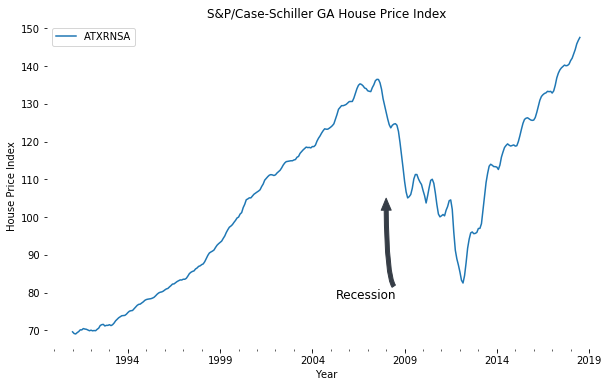

In [46]:
ax = file3.plot(kind='line',x='Month-year',y='ATXRNSA',title="S&P/Case-Schiller GA House Price Index",figsize=(10, 6))
ax.set_ylabel("House Price Index")
ax.set_xlabel("Year")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.annotate('Recession', 
            xy=('2008', 105),
            xycoords='data',
            xytext=(-50,-100),
            textcoords='offset points',
            arrowprops=dict(headwidth=10, width=4, color='#363d46', 
                            connectionstyle="angle3,angleA=0,angleB=-90"),fontsize=12)


# Getting GA Zipcodes

In [116]:
StateSelected = ['GA']
zipcodes=pd.read_csv('free-zipcode-database-Primary.csv')
gazipcodes=zipcodes[zipcodes.State.isin(StateSelected)]
gazipcodes.count()
zipcodes.head(10)

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN
5,631,PO BOX,CASTANER,PR,PRIMARY,18.19,-66.82,NA-US-PR-CASTANER,False,NaN,NaN,NaN
6,602,STANDARD,AGUADA,PR,PRIMARY,18.38,-67.18,NA-US-PR-AGUADA,False,NaN,NaN,NaN
7,603,STANDARD,AGUADILLA,PR,PRIMARY,18.43,-67.15,NA-US-PR-AGUADILLA,False,NaN,NaN,NaN
8,604,PO BOX,AGUADILLA,PR,PRIMARY,18.43,-67.15,NA-US-PR-AGUADILLA,False,NaN,NaN,NaN
9,605,PO BOX,AGUADILLA,PR,PRIMARY,18.43,-67.15,NA-US-PR-AGUADILLA,False,NaN,NaN,NaN


# Perform API Calls from ATTOM to get Full Address List

In [6]:
FullAddress=[]
Street=[]
CityStateZip=[]
Latitude=[]
Longitude=[]
pd.Series(FullAddress)
pd.Series(Latitude)
pd.Series(Longitude)
Data_set=pd.DataFrame({'FullAddress':pd.Series(FullAddress),'Street':pd.Series(Street),'CityStateZip':pd.Series(CityStateZip),
                       'Latitude':pd.Series(Latitude),'Longitude':pd.Series(Longitude)})

In [7]:
Data_set['Zillow format add']=Data_set['Street'].replace(" ", "+",regex=True)
Data_set['Zillow format Zipcity']=Data_set['CityStateZip'].replace(" ", "+",regex=True)
Data_set.head()

,FullAddress,Street,CityStateZip,Latitude,Longitude,Zillow format add,Zillow format Zipcity


In [7]:
# We have total over 660,000 GA address data

# Sample Selected

In [8]:
# create random index
# rindex =  np.array(sample(range(len(Data_set)), 10000))

# suffle the data
# np.random.shuffle(rindex)

# # get 10,000 random rows from Data_set
# Data_set_random = Data_set.iloc[rindex]

In [9]:
# # split 10,000 dataset into 3 subsets

# data_random1=Data_set_random.iloc[0-3000:]
# data_random2=Data_set_random.iloc[3000-6000:]
# data_random3=Data_set_random.iloc[6000-10000:]

In [10]:
# data_random1.to_csv('data_random1.csv')
# data_random2.to_csv('data_random2.csv')
# data_random3.to_csv('data_random3.csv')

# Feed the sample addresses to Zillow API

In [11]:
# Example of getting 10 data from Zillow due to daily limit of 1000 calls
# We actually run 10 times of the following code since our sample size is 10,000
Data_set=Data_set.head(10)

In [12]:
zid = 'X1-ZWz1go72alddzf_8469v'
zpid=[]
zest=[]
addr =[]
city=[]
zipC=[]
type=[]
rooms=[]
sqft=[]
state=[]
lastsoldprice=[]
lastsolddate=[]
year_built=[]
c_value=[]
county=[]
lat =[]
lon =[]
Zindex =[]

for index, row in Data_set.iterrows():
    add=row['Zillow format add']
    statezip=row['Zillow format Zipcity']
    params2=f'{add}&citystatezip={statezip}'
    url2 = f"http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id={zid}&address={params2}"
    
    response2 = requests.get(url2, params=params2)
    
    tree=ET.fromstring(response2.content)
    results=tree.findall('./response/results/result')
    
    if len(results)!=0:
        re=results[0] 
        dic=xmltodict.parse(ET.tostring(re))
        try: 
            
             Zid=dic['result'].get('zpid',np.nan)
             zestimate=dic['result']['zestimate']['amount'].get('#text',np.nan)
             strt=dic['result']['address'].get('street',np.nan)
             zip=dic['result']['address'].get('zipcode',np.nan)
             cit=dic['result']['address'].get('city',np.nan)
             price=dic['result'].get('lastSoldPrice',np.nan)
             solddate=dic['result'].get('lastSoldDate',np.nan)
             room=dic['result'].get('bedrooms',np.nan)
             usecode=dic['result'].get('useCode',np.nan)
             sqftt=dic['result'].get('finishedSqFt',np.nan)
             yearbuilt=dic['result'].get('yearBuilt',np.nan)
             contyvalue=dic['result'].get('taxAssessment',np.nan)
             Zindx =dic['result'].get('localRealEstate',np.nan)
             year_built.append(yearbuilt)
             lati=dic['result']['address'].get('latitude',np.nan)
             longi=dic['result']['address'].get('longitude',np.nan)
             lon.append(longi)
             lat.append(lati)
             zest.append(zestimate)
             zpid.append(Zid)
             addr.append(strt)
             zipC.append(zip)
             city.append(cit)
             lastsoldprice.append(price)
             rooms.append(room)
             type.append(usecode)
             sqft.append(sqftt)
             c_value.append(contyvalue)
             lastsolddate.append(solddate)
             Zindex.append(Zindx)
             longi=[]
             lati=[]
             Zindx=[]
             solddate=[]
             zestimate=[]
             Zid=[]
             price=[]
             room=[]
             usecode=[]
             sqftt=[]
             cit=[]
             usecode=[]
             yearbuilt=[]
             contyvalue=[]
             strt=[]
             print(f'got it updating')
             
        except (KeyError, IndexError):
             print(skip)

In [13]:
d=pd.DataFrame({'Zillow Id':pd.Series(zpid),'Zestimate':pd.Series(zest),'Street':pd.Series(addr),\
                'City':pd.Series(city),'ZipCode':pd.Series(zipC),'lastSold':pd.Series(lastsoldprice),\
                'Bedrooms':pd.Series(rooms),'typeofhome':pd.Series(type),'Squareft':pd.Series(sqft),\
                'YearBuilt':pd.Series(year_built),'CountTax':pd.Series(c_value),\
                'Latitude':pd.Series(lat),'Longitude':pd.Series(lon),'LastSoldDate':pd.Series(lastsolddate),\
                'Z_index':pd.Series(Zindex)})  
df=d.drop_duplicates(['Zillow Id'])

In [14]:
df['LastSold']=df['lastSold'].apply(lambda l: l.get('#text', np.nan) if isinstance(l, dict) else np.nan)
df['Zindex']=df['Z_index'].apply(lambda l: l.get('region', np.nan) if isinstance(l, dict) else np.nan)
df['Z_index']=df['Zindex'].apply(lambda l: l.get('zindexValue', np.nan) if isinstance(l, dict) else np.nan)
df.head()

,Zillow Id,Zestimate,Street,City,ZipCode,lastSold,Bedrooms,typeofhome,Squareft,YearBuilt,CountTax,Latitude,Longitude,LastSoldDate,Z_index,LastSold,Zindex


# Combine data and clean data

In [15]:
# combine data and get 5698 observations

In [8]:
combined_data = pd.read_csv('Combineddata.csv')
combined_data.City=combined_data.City.map(lambda x: x.upper())
combined_data.head()

,Unnamed: 0,Zillow Id,Zestimate,Street,City,ZipCode,lastSold,Bedrooms,typeofhome,Squareft,YearBuilt,CountTax,Latitude,Longitude,LastSoldDate,Z_index,LastSold,Zindex
0,0,93123448,345560.0,256 Buckshot Ln,TIGER,30576.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",4.0,SingleFamily,4200.0,2001.0,290723.0,34.822040,-83.446890,10/1/2002,"165,300",285000.0,"OrderedDict([('@id', '14139'), ('@name', 'Tige..."
1,1,82452558,155747.0,65 Sunrise Dr,GRANTVILLE,30220.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",4.0,SingleFamily,1496.0,2006.0,118800.0,33.229140,-84.825290,11/19/2010,"113,700",54000.0,"OrderedDict([('@id', '45530'), ('@name', 'Gran..."
2,2,111793656,58879.0,2085 Jackson Rd,ROBERTA,31078.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",3.0,Mobile,1152.0,1995.0,57838.0,32.692290,-83.950920,2/12/2018,NaN,56750.0,"OrderedDict([('@id', '18858'), ('@name', 'Knox..."
3,3,2139757076,150542.0,6301 Chief O F Love Rd B-5,SAVANNAH,31419.0,NaN,2.0,Condominium,1300.0,2008.0,NaN,31.993879,-81.281182,NaN,NaN,NaN,"OrderedDict([('@id', '763636'), ('@name', 'The..."
4,4,221933009,233334.0,1900 Bell Ln,BRASELTON,30517.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",0.0,SingleFamily,2653.0,2006.0,192468.0,34.108109,-83.790392,5/26/2017,"275,900",210999.0,"OrderedDict([('@id', '41949'), ('@name', 'Bras..."


In [9]:
combined_data_selected=combined_data[['Zestimate', 'City','ZipCode','Street','Bedrooms', 'LastSoldDate','typeofhome', 
                                      'Squareft', 'YearBuilt', 'CountTax','LastSold','Z_index','Longitude','Latitude']]
combined_data_selected.head()

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Longitude,Latitude
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,2001.0,290723.0,285000.0,"165,300",-83.446890,34.822040
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,2006.0,118800.0,54000.0,"113,700",-84.825290,33.229140
2,58879.0,ROBERTA,31078.0,2085 Jackson Rd,3.0,2/12/2018,Mobile,1152.0,1995.0,57838.0,56750.0,NaN,-83.950920,32.692290
3,150542.0,SAVANNAH,31419.0,6301 Chief O F Love Rd B-5,2.0,NaN,Condominium,1300.0,2008.0,NaN,NaN,NaN,-81.281182,31.993879
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2006.0,192468.0,210999.0,"275,900",-83.790392,34.108109


# Areas with the high Zestimates


In [10]:
comb = combined_data[['Latitude', 'Longitude','Zestimate', 'City', 'Squareft', 'typeofhome']]
comb=comb[comb['Zestimate']<500000]
comb=comb[comb['Squareft']<10000]
comb.head()

,Latitude,Longitude,Zestimate,City,Squareft,typeofhome
0,34.822040,-83.446890,345560.0,TIGER,4200.0,SingleFamily
1,33.229140,-84.825290,155747.0,GRANTVILLE,1496.0,SingleFamily
2,32.692290,-83.950920,58879.0,ROBERTA,1152.0,Mobile
3,31.993879,-81.281182,150542.0,SAVANNAH,1300.0,Condominium
4,34.108109,-83.790392,233334.0,BRASELTON,2653.0,SingleFamily


In [11]:
comb1 = comb.dropna(how='any')

In [12]:
locations = comb1[['Latitude', 'Longitude']].astype(float)
weights = comb1['Zestimate']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))

# What is the makeup of the GA housing market?

In [13]:
Hometype=combined_data.groupby(['typeofhome'])['Zillow Id'].count()
Homes=pd.DataFrame({'type':Hometype}).reset_index()
Homes

,typeofhome,type
0,Apartment,7
1,Condominium,145
2,Duplex,20
3,Miscellaneous,4
4,Mobile,670
5,MultiFamily2To4,21
6,MultiFamily5Plus,2
7,SingleFamily,4638
8,Townhouse,52
9,Triplex,1


In [14]:
Homes["typeofhome"] = Homes["typeofhome"].replace({"Unknown": "Other", "Triplex": "Other", 
                                                   "Miscellaneous": "Other", "MultiFamily2To4": "Other",
                                                   "MultiFamily5Plus": "Other", "Townhouse": "Condominium",
                                                   "VacantResidentialLand": "Other", "Apartment": "Other",
                                                  "Duplex": "Other"})

In [15]:
Home2 = Homes.groupby("typeofhome")['type'].sum()
Home2

typeofhome
Condominium      197
Mobile           670
Other            193
SingleFamily    4638
Name: type, dtype: int64

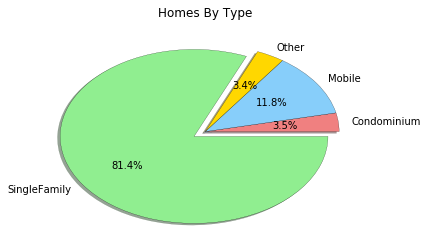

In [16]:
#Build Pie Chart
type_city = Home2.index
colors=["lightcoral","lightskyblue","gold", "lightgreen", "pink"]
explode=[0,0,0,0.1]
plt.pie(Home2,explode=explode,labels=type_city,colors=colors,autopct="%1.1f%%",
        shadow=True,wedgeprops = {'linewidth': .2, 'edgecolor': 'black'},startangle=0)
plt.title('Homes By Type')
plt.show()
# plt.savefig("Homes_Type.png")

# How does individual features effect the value of the house?

In [25]:
dselect=combined_data_selected[['Bedrooms', 'LastSold']]
zdata=dselect.dropna(how='any')
dselect2=combined_data_selected[['Bedrooms', 'Zestimate']]
zdata2=dselect2.dropna(how='any')

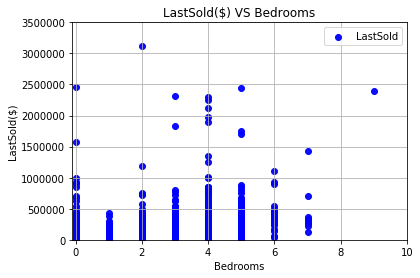

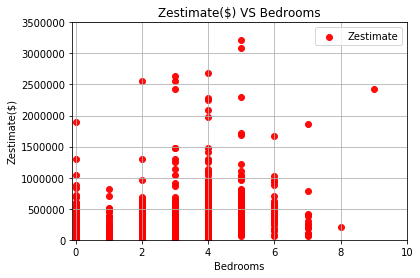

In [26]:
X = zdata['Bedrooms']
Y = zdata['LastSold']

Xa = zdata2['Bedrooms']
Ya = zdata2['Zestimate']

plt.scatter(X,Y,alpha=0.95,c='b')
plt.xlabel('Bedrooms')
plt.ylabel('LastSold($)')
plt.ylim(0,3500000)
plt.xlim(-0.1,10)
plt.legend()
plt.grid()
plt.title('LastSold($) VS Bedrooms')
plt.show()


plt.scatter(Xa,Ya,alpha=0.95,c='r')
plt.xlabel('Bedrooms')
plt.ylabel('Zestimate($)')
plt.ylim(0,3500000)
plt.xlim(-0.1,10)
plt.legend()
plt.grid()
plt.title('Zestimate($) VS Bedrooms')
plt.show()

In [27]:
dselect=combined_data_selected[['Squareft', 'LastSold']]
zdata=dselect.dropna(how='any')

dselect2=combined_data_selected[['Squareft', 'Zestimate']]
zdata2=dselect2.dropna(how='any')

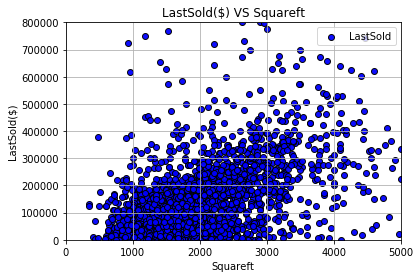

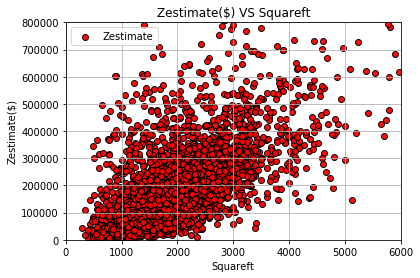

In [28]:
X1 = zdata['Squareft']
Y1 = zdata['LastSold']

Xb = zdata2['Squareft']
Yb = zdata2['Zestimate']

plt.scatter(X1,Y1,alpha=0.95,c='b',edgecolor = 'black')
plt.xlabel('Squareft')
plt.ylabel('LastSold($)')
plt.ylim(0,800000)
plt.xlim(-0.1,5000)
plt.legend()
plt.grid()
plt.title('LastSold($) VS Squareft')
plt.show()

plt.scatter(Xb,Yb,alpha=0.95,c='r',edgecolor = 'black')
plt.xlabel('Squareft')
plt.ylabel('Zestimate($)')
plt.ylim(0,800000)
plt.xlim(-0.1,6000)
plt.legend()
plt.grid()
plt.title('Zestimate($) VS Squareft')
plt.show()

In [29]:
dselect=combined_data_selected[['YearBuilt', 'LastSold']]
zdata=dselect.dropna(how='any')

dselect2=combined_data_selected[['YearBuilt', 'Zestimate']]
zdata2=dselect2.dropna(how='any')

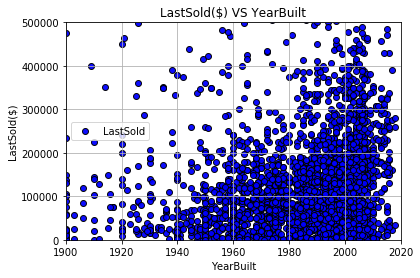

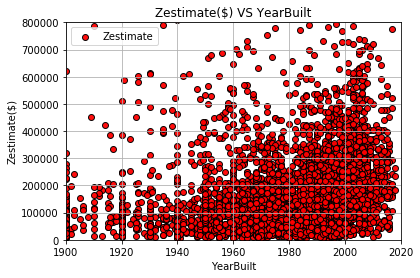

In [30]:
X2 = zdata['YearBuilt']
Y2 = zdata['LastSold']

Xc = zdata2['YearBuilt']
Yc = zdata2['Zestimate']

plt.scatter(X2,Y2,alpha=0.95,c='b',edgecolor = 'k')
plt.xlabel('YearBuilt')
plt.ylabel('LastSold($)')
plt.ylim(0,500000)
plt.xlim(1900,2020)
plt.legend()
plt.grid()
plt.title('LastSold($) VS YearBuilt')
plt.show()


plt.scatter(Xc,Yc,alpha=0.95,c='r',edgecolor = 'k')
plt.xlabel('YearBuilt')
plt.ylabel('Zestimate($)')
plt.ylim(0,800000)
plt.xlim(1900,2020)
plt.legend()
plt.grid()
plt.title('Zestimate($) VS YearBuilt')
plt.show()

# How do multiple features effect the value?

In [58]:
df_zestimate=combined_data[['Zestimate', 'Bedrooms','YearBuilt','Squareft']]
df_lastsold=combined_data[['LastSold', 'Bedrooms','YearBuilt','Squareft']]

df_zestimate=df_zestimate.dropna(how='any')
df_lastsold=df_lastsold.dropna(how='any')

df_zestimate=df_zestimate[df_zestimate['Zestimate']<500000]
df_zestimate=df_zestimate[df_zestimate['Squareft']<10000]

df_lastsold=df_lastsold[df_lastsold['LastSold']<500000]
df_lastsold=df_lastsold[df_lastsold['Squareft']<10000]

In [57]:
# Regression 1
X = df_zestimate[['Squareft', 'Bedrooms', 'YearBuilt']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg1 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 2
X = df_zestimate[['Squareft', 'Bedrooms']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg2 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 3
X = df_zestimate[['Squareft', 'YearBuilt']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg3 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 4
X = df_zestimate[['Bedrooms', 'YearBuilt']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg4 = sm.OLS(Y.astype(float), X1.astype(float)).fit()


reg1.summary(),reg2.summary(),reg3.summary(),reg4.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Zestimate   R-squared:                       0.415
 Model:                            OLS   Adj. R-squared:                  0.414
 Method:                 Least Squares   F-statistic:                     798.3
 Date:                Thu, 11 Oct 2018   Prob (F-statistic):               0.00
 Time:                        21:42:22   Log-Likelihood:                -43142.
 No. Observations:                3380   AIC:                         8.629e+04
 Df Residuals:                    3376   BIC:                         8.632e+04
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [53]:
# Regression 1
X = df_lastsold[['Squareft', 'Bedrooms', 'YearBuilt','Longitude','Latitude']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg1 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 2
X = df_lastsold[['Squareft', 'Bedrooms']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg2 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 3
X = df_lastsold[['Squareft', 'YearBuilt']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg3 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

# Regression 4
X = df_lastsold[['Bedrooms', 'YearBuilt']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg4 = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg1.summary(),reg2.summary(),reg3.summary(),reg4.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               LastSold   R-squared:                       0.322
 Model:                            OLS   Adj. R-squared:                  0.321
 Method:                 Least Squares   F-statistic:                     217.1
 Date:                Thu, 11 Oct 2018   Prob (F-statistic):          7.07e-190
 Time:                        21:40:23   Log-Likelihood:                -29273.
 No. Observations:                2291   AIC:                         5.856e+04
 Df Residuals:                    2285   BIC:                         5.859e+04
 Df Model:                           5                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

# Can we find investment opportunities?

In [51]:
df4=combined_data_selected[combined_data_selected['Zestimate'].notnull()]
df4=combined_data_selected[combined_data_selected['LastSold'].notnull()]
df4

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Longitude,Latitude
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,2001.0,290723.0,285000.0,"165,300",-83.446890,34.822040
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,2006.0,118800.0,54000.0,"113,700",-84.825290,33.229140
2,58879.0,ROBERTA,31078.0,2085 Jackson Rd,3.0,2/12/2018,Mobile,1152.0,1995.0,57838.0,56750.0,NaN,-83.950920,32.692290
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2006.0,192468.0,210999.0,"275,900",-83.790392,34.108109
5,12994.0,BUENA VISTA,31803.0,2192 Pineville Rd,0.0,5/4/2006,SingleFamily,912.0,1969.0,40464.0,29200.0,NaN,-84.545657,32.276539
7,40795.0,WRAY,31798.0,114 Red Rd,2.0,3/23/2018,SingleFamily,804.0,1977.0,30202.0,39900.0,NaN,-83.010673,31.775404
8,46476.0,ROCKY FACE,30740.0,887 Old Babb Rd,NaN,1/1/1997,Mobile,1120.0,1990.0,23037.0,9000.0,"142,200",-85.046656,34.740660
9,109175.0,COLQUITT,39837.0,20 Red Oak Rd,2.0,8/23/2005,SingleFamily,1568.0,2006.0,48737.0,10000.0,NaN,-84.694656,31.121459
10,NaN,CALHOUN,30701.0,151 Cooper Rd SE,0.0,1/3/2013,SingleFamily,NaN,NaN,26200.0,200000.0,"126,700",-84.874699,34.442460
11,57489.0,ALBANY,31705.0,4860 Pinto Dr,3.0,2/23/2016,SingleFamily,1375.0,1973.0,62000.0,58000.0,"82,500",-84.102703,31.460254


In [52]:
df4['Difference']=((df4['LastSold']-df4['Zestimate'])/df4['Zestimate'])*100
df4['Market Value']=2.5*df4['CountTax']
df4['Market Value diff']=((df4['LastSold']-df4['Market Value'])/df4['Market Value'])*100

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [53]:
df4['LastSoldDate'].astype(date)
df4['YearSold']= pd.to_datetime(df4['LastSoldDate']).dt.to_period('y')
df4['YearBuilt']=pd.to_datetime(df4['YearBuilt']).dt.to_period('y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:

df4['Two Year Difference']=date.today()-relativedelta(years=+2)
df4['Two Year Difference']=pd.to_datetime(df4['Two Year Difference']).dt.to_period('y')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
df4=df4[df4['LastSold']>30000]
df4=df4[df4['YearSold']>df4['YearBuilt']]
df4=df4[df4['YearSold']>df4['Two Year Difference']]
df4.sort_values('Difference',ascending=False)

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Longitude,Latitude,Difference,Market Value,Market Value diff,YearSold,Two Year Difference
4303,129367.0,DECATUR,30034.0,3832 River Ridge Ct,5.0,05/15/2017,SingleFamily,1500.0,1970,95500.0,5596636.0,NaN,-84.269818,33.669617,4226.169734,238750.0,2244.140733,2017,2016
1386,160077.0,OAKWOOD,30566.0,4121 Pebble Creek Ln,4.0,6/2/2017,Triplex,1817.0,1970,58315.0,1900000.0,"139,100",-83.886883,34.226880,1086.928791,145787.5,1203.266741,2017,2016
4751,92365.0,RIVERDALE,30274.0,8610 Thomas Ln,3.0,05/31/2017,Townhouse,1530.0,1970,56654.0,770000.0,"87,300",-84.409278,33.521217,733.649110,141635.0,443.650934,2017,2016
3594,18907.0,ROYSTON,30662.0,288 Roan Williams Rd,2.0,03/06/2018,SingleFamily,352.0,1970,8719.0,125000.0,NaN,-83.146212,34.203989,561.130798,21797.5,473.460259,2018,2016
4942,42488.0,EATONTON,31024.0,227 Napier Rd,NaN,8/25/2017,SingleFamily,3384.0,1970,106524.0,220000.0,NaN,-83.381972,33.185588,417.793259,266310.0,-17.389508,2017,2016
3705,145023.0,AUSTELL,30168.0,1138 Summerstone Trce,3.0,11/13/2017,SingleFamily,1500.0,1970,99170.0,627527.0,"132,100",-84.585791,33.776927,332.708605,247925.0,153.111626,2017,2016
3736,105459.0,LAGRANGE,30240.0,105 Smokey Cv,4.0,04/25/2018,SingleFamily,2521.0,1970,20000.0,274999.0,NaN,-85.018623,32.948912,160.763899,50000.0,449.998000,2018,2016
420,2636820.0,CANTON,30115.0,4251 Holly Springs Pkwy,3.0,4/17/2018,SingleFamily,1568.0,1970,1039900.0,6000000.0,"193,700",-84.508419,34.152355,127.546818,2599750.0,130.791422,2018,2016
3732,342749.0,OCILLA,31774.0,801 Daffodil Rd,2.0,11/03/2017,SingleFamily,1176.0,1970,284611.0,750000.0,NaN,-83.145900,31.525400,118.819019,711527.5,5.407029,2017,2016
861,23403.0,JULIETTE,31046.0,3083 Rumble Rd,NaN,5/12/2017,Mobile,1344.0,1970,46100.0,50000.0,"171,700",-83.791978,32.986676,113.647823,115250.0,-56.616052,2017,2016


In [56]:
df4=df4[df4['Market Value diff'] > 0]
dselect = ['SingleFamily']
df4= df4[df4.typeofhome.isin(dselect)]

In [57]:
mean_diff=df4.groupby(['City','ZipCode'])['Market Value diff'].mean().reset_index()
mean_diff = mean_diff.sort_values(['Market Value diff','City','ZipCode'], ascending=[False,True,True])
mean_diff.head(10)

,City,ZipCode,Market Value diff
7,DECATUR,30034.0,2244.140733
11,POOLER,31322.0,1523.376623
12,ROYSTON,30662.0,473.460259
8,LAGRANGE,30240.0,449.998000
0,ATHENS,30606.0,421.862667
1,ATLANTA,30314.0,281.027668
3,BAXLEY,31513.0,241.622708
9,LAWRENCEVILLE,30046.0,188.777778
14,TYRONE,30290.0,182.613333
2,AUSTELL,30168.0,153.111626


In [58]:
df5=df4[df4['Difference'] > 0]
dselect = ['SingleFamily']
df5= df5[df5.typeofhome.isin(dselect)]

In [59]:
mean_diff2=df5.groupby(['City','ZipCode'])['Difference'].mean().reset_index()
mean_diff2 = mean_diff2.sort_values(['Difference','City','ZipCode'], ascending=[False,True,True])
mean_diff2.head(10)

,City,ZipCode,Difference
4,DECATUR,30034.0,4226.169734
8,ROYSTON,30662.0,561.130798
1,AUSTELL,30168.0,332.708605
5,LAGRANGE,30240.0,160.763899
2,CANTON,30115.0,127.546818
6,OCILLA,31774.0,118.819019
3,CLERMONT,30527.0,110.339865
0,ATHENS,30606.0,60.812615
9,TYRONE,30290.0,9.563606
7,POOLER,31322.0,5.732566


In [60]:
df_nodups= df4.drop_duplicates('ZipCode')
merge1 = pd.merge(mean_diff, df4, how='left', on='ZipCode')
df_nodups2= df5.drop_duplicates('ZipCode')
merge2 = pd.merge(mean_diff2, df5, how='left', on='ZipCode')

In [61]:
marker_locations = merge1[['Latitude', 'Longitude']]
marker_locations2 = merge2[['Latitude', 'Longitude']]

market_value1 = gmaps.symbol_layer(marker_locations, fill_color='blue',
                                   stroke_color= 'rgba(0, 150, 0, 0.4)', scale=6)

zestimate1 = gmaps.symbol_layer(marker_locations2, fill_color='red',
                                   stroke_color= 'rgba(200, 0, 0, 0.4)', scale=6)

fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations)
fig.add_layer(market_value1)
fig.add_layer(zestimate1)
fig

Figure(layout=FigureLayout(height='420px'))

# Are they just getting expensive or there are actually sales

In [115]:
salesmarket=combined_data_selected[combined_data_selected['LastSold'].notnull()]
salesmarket['LastSoldDate'].astype(date)
salesmarket['YearSold']= pd.to_datetime(salesmarket['LastSoldDate']).dt.to_period('y')
Yoysales=salesmarket.groupby('YearSold').size()
Yoysales= salesmarket.groupby('YearSold') \
       .agg({'typeofhome':'size', 'Zestimate':'mean'}) \
       .rename(columns={'typeofhome':'count of homessold','Zestimate':'Average Zestimate'}) \
       .reset_index()
#Yoysales=Yoysales.sort_values(by='count of homessold',ascending=False)
Yoysales.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,YearSold,count of homessold,Average Zestimate
0,1900,1,160240.00
1,1974,3,143546.00
2,1976,4,173282.00
3,1977,4,154844.00
4,1978,4,178392.25


Text(-50,-100,'Recession')

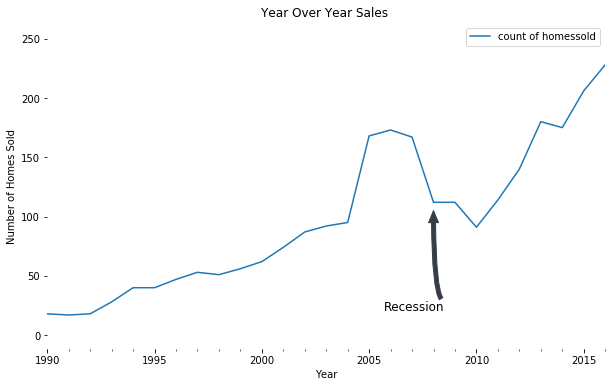

In [114]:
nx = Yoysales.plot(kind='line',x='YearSold',y='count of homessold',title="Year Over Year Sales ",figsize=(10, 6),xlim=(20,46))
nx.set_ylabel("Number of Homes Sold")
nx.set_xlabel("Year")
nx.spines['right'].set_visible(False)
nx.spines['top'].set_visible(False)
nx.spines['left'].set_visible(False)
nx.spines['bottom'].set_visible(False)
nx.annotate('Recession', 
            xy=('2008', 105),
            xycoords='data',
            xytext=(-50,-100),
            textcoords='offset points',
            arrowprops=dict(headwidth=10, width=4, color='#363d46', 
                            connectionstyle="angle3,angleA=0,angleB=-90"),fontsize=12)

# Can We find Any Listings In Our Preffered ZipCodes?

In [62]:
combined_data_selected=combined_data[['Zestimate', 'City','ZipCode','Street','Bedrooms', 'LastSoldDate','typeofhome', 
                                      'Squareft', 'YearBuilt', 'CountTax','LastSold','Z_index','Longitude','Latitude']]
combined_data_selected.head()

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Longitude,Latitude
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,2001.0,290723.0,285000.0,"165,300",-83.446890,34.822040
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,2006.0,118800.0,54000.0,"113,700",-84.825290,33.229140
2,58879.0,ROBERTA,31078.0,2085 Jackson Rd,3.0,2/12/2018,Mobile,1152.0,1995.0,57838.0,56750.0,NaN,-83.950920,32.692290
3,150542.0,SAVANNAH,31419.0,6301 Chief O F Love Rd B-5,2.0,NaN,Condominium,1300.0,2008.0,NaN,NaN,NaN,-81.281182,31.993879
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2006.0,192468.0,210999.0,"275,900",-83.790392,34.108109


In [89]:
stillonmarket=combined_data_selected[combined_data_selected['LastSold'].isnull()]
#len(stillonmarket)
stillonmarket.head()

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Longitude,Latitude
3,150542.0,SAVANNAH,31419.0,6301 Chief O F Love Rd B-5,2.0,NaN,Condominium,1300.0,2008.0,NaN,NaN,NaN,-81.281182,31.993879
6,187997.0,ATLANTA,30308.0,300 Peachtree St NE APT 23B,1.0,NaN,Condominium,621.0,1962.0,NaN,NaN,"191,200",-84.386487,33.763824
12,14401.0,SYLVANIA,30467.0,134 Speckled Cat,0.0,NaN,Mobile,1152.0,1998.0,22010.0,NaN,NaN,-81.580028,32.551910
13,134705.0,WARM SPRINGS,31830.0,1651 White House Pkwy,2.0,NaN,SingleFamily,1920.0,1960.0,76100.0,NaN,"66,200",-84.680929,32.894643
14,NaN,ROCKMART,30153.0,95 Tolbert Rd,0.0,NaN,SingleFamily,NaN,NaN,7244.0,NaN,"103,500",-85.069636,33.884058


In [64]:
in_range=stillonmarket.Zestimate<500000
in_range2=stillonmarket[in_range]
inventory= in_range2.groupby(['ZipCode','City']) \
       .agg({'typeofhome':'size', 'Zestimate':'mean'}) \
       .rename(columns={'typeofhome':'count of Listings','Zestimate':'Average Zestimate'}) \
       .reset_index()
inventsorted=inventory.sort_values(by='count of Listings',ascending=False)

In [85]:
#mean_diff2
mean_diff3=mean_diff[['ZipCode','City']]
mean_diff4=mean_diff2[['ZipCode','City']]
Append_prefferedZips=mean_diff3.append(mean_diff4,ignore_index=True)
Append_prefferedZips=Append_prefferedZips.drop_duplicates('ZipCode')
#Append_prefferedZips

Invent=pd.merge(Append_prefferedZips,inventsorted[['ZipCode','count of Listings','Average Zestimate']],how='inner',on='ZipCode')
Invent=Invent[['ZipCode','City','count of Listings','Average Zestimate']].sort_values('count of Listings',ascending=False).reset_index()
Invent=Invent[['ZipCode','City','count of Listings','Average Zestimate']]
Invent

,ZipCode,City,count of Listings,Average Zestimate
0,30240.0,LAGRANGE,7,167334.857143
1,31774.0,OCILLA,7,108125.714286
2,31513.0,BAXLEY,6,103326.666667
3,30606.0,ATHENS,3,364144.333333
4,30662.0,ROYSTON,2,196232.000000
5,30314.0,ATLANTA,2,146278.000000
6,30034.0,DECATUR,1,194155.000000
7,31322.0,POOLER,1,168409.000000
8,30046.0,LAWRENCEVILLE,1,250578.000000
9,30290.0,TYRONE,1,374541.000000


## Limitations:
Sample Size
How long was the house on the market?
Zillow does not provide tax assessment for current year, so the market value might be different from a year ago.  
Other factors could distort the market. e.g. Amazon new HQ2